In [47]:
from cgeniepy.ecology import EcoModel
import pandas as pd

from pathlib import Path
model_path = Path("../model")

## list all folders containing "EXP1'
exp1 = [str(x) for x in model_path.iterdir() if x.is_dir() and "EXP1" in x.name]
exp2 = [str(x) for x in model_path.iterdir() if x.is_dir() and "EXP2" in x.name]
exp3 = [str(x) for x in model_path.iterdir() if x.is_dir() and "EXP3" in x.name]

m1 = EcoModel(exp1)
m2 = EcoModel(exp2)
m3 = EcoModel(exp3)
exp_list = [m1, m2, m3]

grid_area = m2.get_var('grid_area').array.isel(model=0)

In [80]:
df_list = []
effect = ['solar effect', 'CO2 effect', 'both']
for i, m in enumerate(exp_list):
    ## get raw data for exp1
    exp_size = m.get_var('eco2D_Size_Mean')
    exp_phyto = m.get_pft('phyto')
    exp_mixo = m.get_pft('mixo')
    exp_zoo = m.get_pft('zoo')

    zoo_biomass = exp_zoo.array.sum(dim='variable') * grid_area * 80.8 * 1E-3 * 12 * 1E-15 # Pg C
    zoo_biomass = zoo_biomass.sum(dim=['lat', 'lon'])
    df_zoo = zoo_biomass.to_dataframe(name='zooplankton biomass (Pg C)')
    
    phyto_biomass = exp_phyto.array.sum(dim='variable') * grid_area * 80.8 * 1E-3 * 12 * 1E-15 # Pg C
    phyto_biomass = phyto_biomass.sum(dim=['lat', 'lon'])
    df_phyto = phyto_biomass.to_dataframe(name='phytoplankton biomass (Pg C)')
    
    mixo_biomass = exp_mixo.array.sum(dim='variable') * grid_area * 80.8 * 1E-3 * 12 * 1E-15 # Pg C
    mixo_biomass = mixo_biomass.sum(dim=['lat', 'lon'])
    df_mixo = mixo_biomass.to_dataframe(name='mixoplankton biomass (Pg C)')
    
    exp_size_mean = exp_size.array.mean(dim=['lat', 'lon'])
    df_size = exp_size_mean.to_dataframe(name='size mean (μm)')
    
    df = pd.concat([df_zoo, df_phyto, df_mixo, df_size], axis=1)
    df['exp'] = effect[i]
    df_list.append(df)

df_all = pd.concat(df_list, axis = 0)
df_all.to_csv("../data/eccosystem_response_kpg.csv")

In [88]:
## convert to long format
df_all = pd.read_csv("../data/eccosystem_response_kpg.csv")

df_all['time'] = df_all['time'] - 100
## rename exp to 'Effect of the impact'
df_all = df_all.rename(columns={'exp':'Effect of the impact',
                                'time' : "Time after the impact (kyr)"})

## calculate the mixotroph fraction
df_all['mixotroph fraction'] = df_all['mixoplankton biomass (Pg C)'] / (df_all['zooplankton biomass (Pg C)']+df_all['mixoplankton biomass (Pg C)'] + df_all['phytoplankton biomass (Pg C)'])

## remove model column
df_all = df_all.drop(columns=['model'])
df_long = pd.melt(df_all, id_vars=['Time after the impact (kyr)','Effect of the impact'], value_vars=['zooplankton biomass (Pg C)', 'phytoplankton biomass (Pg C)', 'mixoplankton biomass (Pg C)', 'size mean (μm)', 'mixotroph fraction'])

<Figure size 640x480 with 0 Axes>

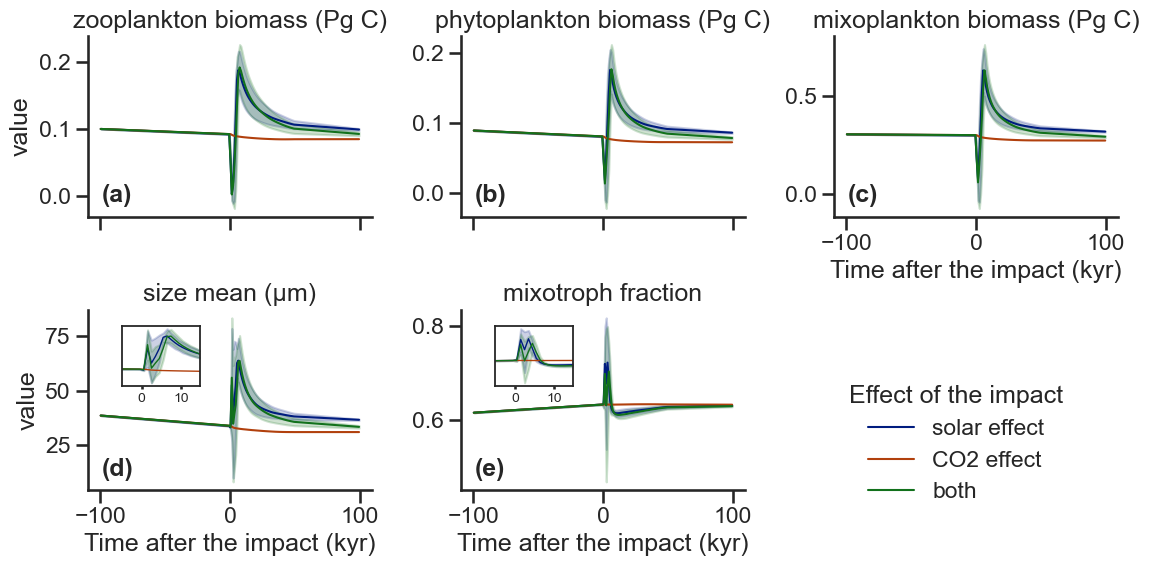

In [117]:
import seaborn as sns

import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## create figure
sns.set_style("ticks")
sns.set_context("talk")
sns.despine()

## facet grid
g = sns.FacetGrid(df_long, col="variable", hue="Effect of the impact",
                  col_wrap=3, height=3, aspect=1.3,
                  palette="dark",
                  sharey=False)
## plot
g.map(sns.lineplot, "Time after the impact (kyr)", "value", errorbar="sd", linewidth=1.5)

## annotate each subplot using alphabetical letters
import string
g.set_titles("{col_name}")
g.add_legend(loc='lower right', bbox_to_anchor=(0.8, 0.1))

for i,ax in enumerate(g.axes.ravel()):
    letter = string.ascii_lowercase[i]
    # Get the corresponding letter from the alphabet
    ax.annotate(f"({letter})", xy=(0.05, 0.08),
                weight='bold',
                xycoords="axes fraction")
    
    if i >=3:
        ## add zoom region inset axes for size mean and mixotroph fraction
        ## add zoom region inset axes for size mean and mixotroph fraction
        axins = inset_axes(ax,
                   width="25%",
                   height="30%",
                    bbox_transform=ax.transAxes,
                     bbox_to_anchor=(0.0, 0.0, 1.1, 1.1),
                   loc='upper left',
                   borderpad=1.5)
        ## plot inset axes for size mean and mixotroph fraction
        # xlim (0,10)
        axins.set_xlim(-5, 15)
        axins.tick_params(axis='x', labelsize=10, length=2)
        axins_border_width = 1.3
        axins.spines['bottom'].set_linewidth(axins_border_width)
        axins.spines['left'].set_linewidth(axins_border_width)
        axins.spines['top'].set_linewidth(axins_border_width)
        axins.spines['right'].set_linewidth(axins_border_width)

        sns.lineplot(x="Time after the impact (kyr)", y="value",
                     hue="Effect of the impact",
                     data=df_long[df_long['variable']==df_long['variable'].unique()[i]],
                     ax=axins, legend=False, linewidth=1,
                     palette="dark")
        ## remove all ticks and labels
        axins.set_yticks([])
        axins.set_xlabel('')
        axins.set_ylabel('')


g.savefig("../output/fig4.png", dpi=300)